#  OPTIMIZED TEETH CLASSIFICATION PIPELINE

##  STEP 1: Import Libraries and Setup

In [1]:
# Core libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,
    LearningRateScheduler, TensorBoard
)
from tensorflow.keras import backend as K

# Computer Vision
import cv2
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support
)

# Set styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuration
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Enable mixed precision for faster training
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f" TensorFlow Version: {tf.__version__}")
print(f" GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f" Mixed Precision: {policy.name}")

 TensorFlow Version: 2.19.0
 GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 Mixed Precision: mixed_float16


##  STEP 2: Mount Drive and Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract dataset
import zipfile

zip_file_path = '/content/drive/MyDrive/Teeth DataSet.zip'
extracted_root_path = '/content/Teeth_Dataset'

if not os.path.exists(extracted_root_path):
    print(f"Extracting {zip_file_path}...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_root_path)
    print(" Extraction complete.")
else:
    print(f" Dataset already extracted.")

DATASET_PATH = os.path.join(extracted_root_path, 'Teeth_Dataset')
print(f"Dataset path: {DATASET_PATH}")

Extracting /content/drive/MyDrive/Teeth DataSet.zip...
 Extraction complete.
Dataset path: /content/Teeth_Dataset/Teeth_Dataset


##  STEP 3: Optimized Configuration

In [4]:
class OptimizedConfig:
    """Optimized hyperparameters based on best practices"""

    # Data paths
    DATASET_PATH = DATASET_PATH
    TRAIN_PATH = os.path.join(DATASET_PATH, 'Training')
    VAL_PATH = os.path.join(DATASET_PATH, 'Validation')
    TEST_PATH = os.path.join(DATASET_PATH, 'Testing')

    # Model parameters
    IMG_SIZE = 256
    BATCH_SIZE = 16  # Smaller batch for better generalization
    NUM_CLASSES = 7

    # Training parameters
    EPOCHS = 150
    INITIAL_LR = 1e-3
    MIN_LR = 1e-7

    # Augmentation parameters
    MIXUP_ALPHA = 0.2
    CUTOUT_SIZE = 32
    LABEL_SMOOTHING = 0.1

    # Advanced techniques
    USE_MIXUP = True
    USE_CUTOUT = True
    USE_TTA = True
    TTA_STEPS = 5

    # Regularization
    DROPOUT_RATE = 0.3
    L2_REG = 1e-4

config = OptimizedConfig()

print("="*80)
print("OPTIMIZED CONFIGURATION")
print("="*80)
print(f"Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Initial LR: {config.INITIAL_LR}")
print(f"Mixup Alpha: {config.MIXUP_ALPHA}")
print(f"Cutout Size: {config.CUTOUT_SIZE}")
print(f"Label Smoothing: {config.LABEL_SMOOTHING}")
print(f"Use TTA: {config.USE_TTA}")
print("="*80)

OPTIMIZED CONFIGURATION
Image Size: 256x256
Batch Size: 16
Epochs: 150
Initial LR: 0.001
Mixup Alpha: 0.2
Cutout Size: 32
Label Smoothing: 0.1
Use TTA: True


##  STEP 4: Data Loading and Analysis

In [5]:
# Get categories
categories = sorted([d for d in os.listdir(config.TRAIN_PATH)
                    if os.path.isdir(os.path.join(config.TRAIN_PATH, d))
                    and not d.startswith('out')])

print(f"Categories: {categories}")
print(f"Number of classes: {len(categories)}")

# Create DataFrame
data_list = []

for split_name, split_path in [('train', config.TRAIN_PATH),
                               ('val', config.VAL_PATH),
                               ('test', config.TEST_PATH)]:
    for category in categories:
        cat_path = os.path.join(split_path, category)
        image_files = [f for f in os.listdir(cat_path) if f.endswith('.jpg')]

        for img_file in image_files:
            data_list.append({
                'image_path': os.path.join(cat_path, img_file),
                'class': category,
                'filename': img_file,
                'split': split_name
            })

df = pd.DataFrame(data_list)

# Add numerical labels
class_to_idx = {cls: idx for idx, cls in enumerate(categories)}
df['label'] = df['class'].map(class_to_idx)

print(f"\nTotal images: {len(df)}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nClass distribution:")
print(df['class'].value_counts())

df.head()

Categories: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Number of classes: 7

Total images: 5143

Split distribution:
split
train    3087
val      1028
test     1028
Name: count, dtype: int64

Class distribution:
class
MC     900
OLP    900
CaS    800
CoS    748
OT     655
Gum    600
OC     540
Name: count, dtype: int64


,image_path,class,filename,split,label
0,/content/Teeth_Dataset/Teeth_Dataset/Training/...,CaS,a_135_0_2057.jpg,train,0
1,/content/Teeth_Dataset/Teeth_Dataset/Training/...,CaS,a_123_0_1329.jpg,train,0
2,/content/Teeth_Dataset/Teeth_Dataset/Training/...,CaS,a_79_0_7217.jpg,train,0
3,/content/Teeth_Dataset/Teeth_Dataset/Training/...,CaS,a_98_0_9734.jpg,train,0
4,/content/Teeth_Dataset/Teeth_Dataset/Training/...,CaS,a_129_0_758.jpg,train,0


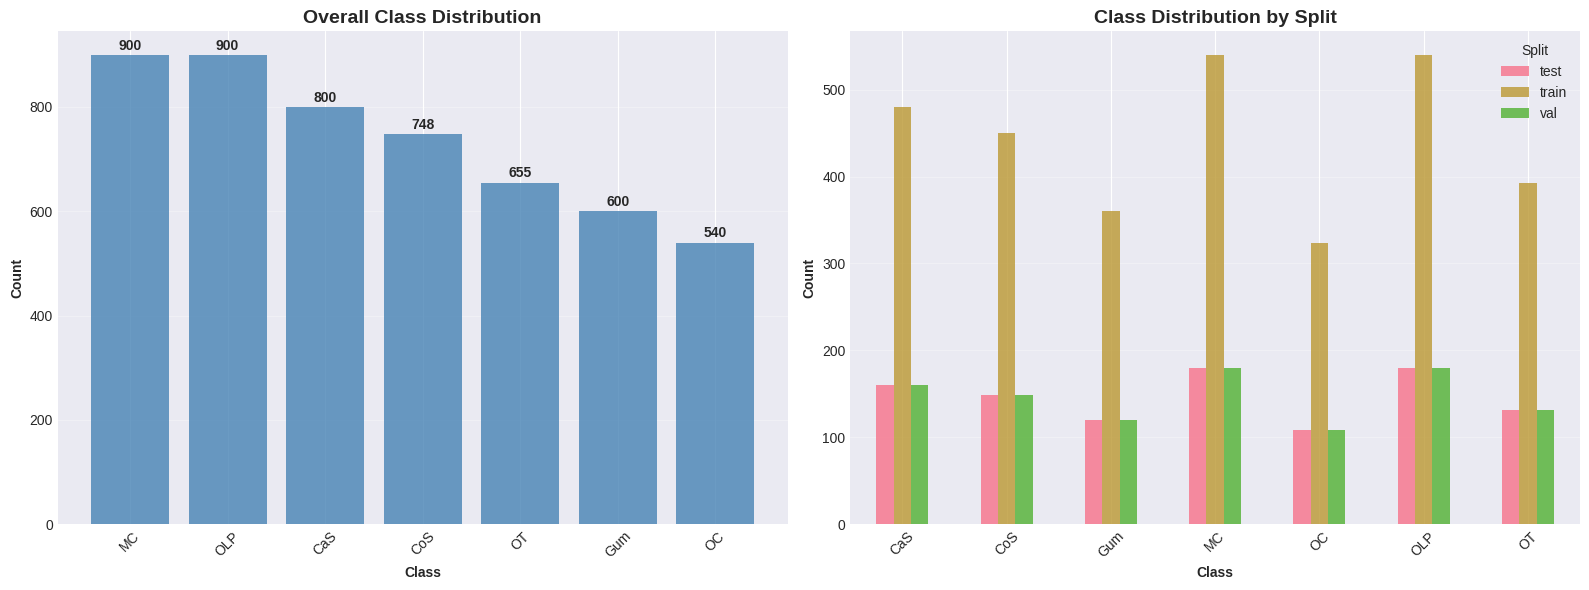


 Class Imbalance Ratio: 1.67:1
 Moderate imbalance detected - will use class weights


In [6]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overall distribution
class_counts = df['class'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color='steelblue', alpha=0.8)
axes[0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontweight='bold')
axes[0].set_ylabel('Count', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

for i, (cat, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# Per-split distribution
split_dist = df.groupby(['split', 'class']).size().unstack(fill_value=0)
split_dist.T.plot(kind='bar', ax=axes[1], alpha=0.8)
axes[1].set_title('Class Distribution by Split', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].legend(title='Split')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Class imbalance ratio
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\n Class Imbalance Ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print(" Moderate imbalance detected - will use class weights")

##  STEP 5: Advanced Augmentation Functions

In [7]:
def cutout_augmentation(image, size=32):
    """Random erasing/cutout augmentation"""
    h, w = image.shape[:2]

    # Random position
    y = np.random.randint(h)
    x = np.random.randint(w)

    # Calculate boundaries
    y1 = np.clip(y - size // 2, 0, h)
    y2 = np.clip(y + size // 2, 0, h)
    x1 = np.clip(x - size // 2, 0, w)
    x2 = np.clip(x + size // 2, 0, w)

    # Apply cutout
    if np.random.random() > 0.5:
        image[y1:y2, x1:x2, :] = np.random.rand(y2-y1, x2-x1, 3)
    else:
        image[y1:y2, x1:x2, :] = image.mean()

    return image

# Create data generators with heavy augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='reflect',
    preprocessing_function=lambda x: cutout_augmentation(x, config.CUTOUT_SIZE) if config.USE_CUTOUT else x
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print(" Advanced augmentation functions created")

 Advanced augmentation functions created


In [8]:
# Create data flows
train_generator = train_datagen.flow_from_directory(
    config.TRAIN_PATH,
    target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
    classes=categories
)

val_generator = val_datagen.flow_from_directory(
    config.VAL_PATH,
    target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    classes=categories
)

test_generator = test_datagen.flow_from_directory(
    config.TEST_PATH,
    target_size=(config.IMG_SIZE, config.IMG_SIZE),
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
    classes=categories
)

print(f"\n Data Generators Created:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.

 Data Generators Created:
   Training samples: 3087
   Validation samples: 1028
   Test samples: 1028


##  STEP 6: Visualize Augmentation Effects

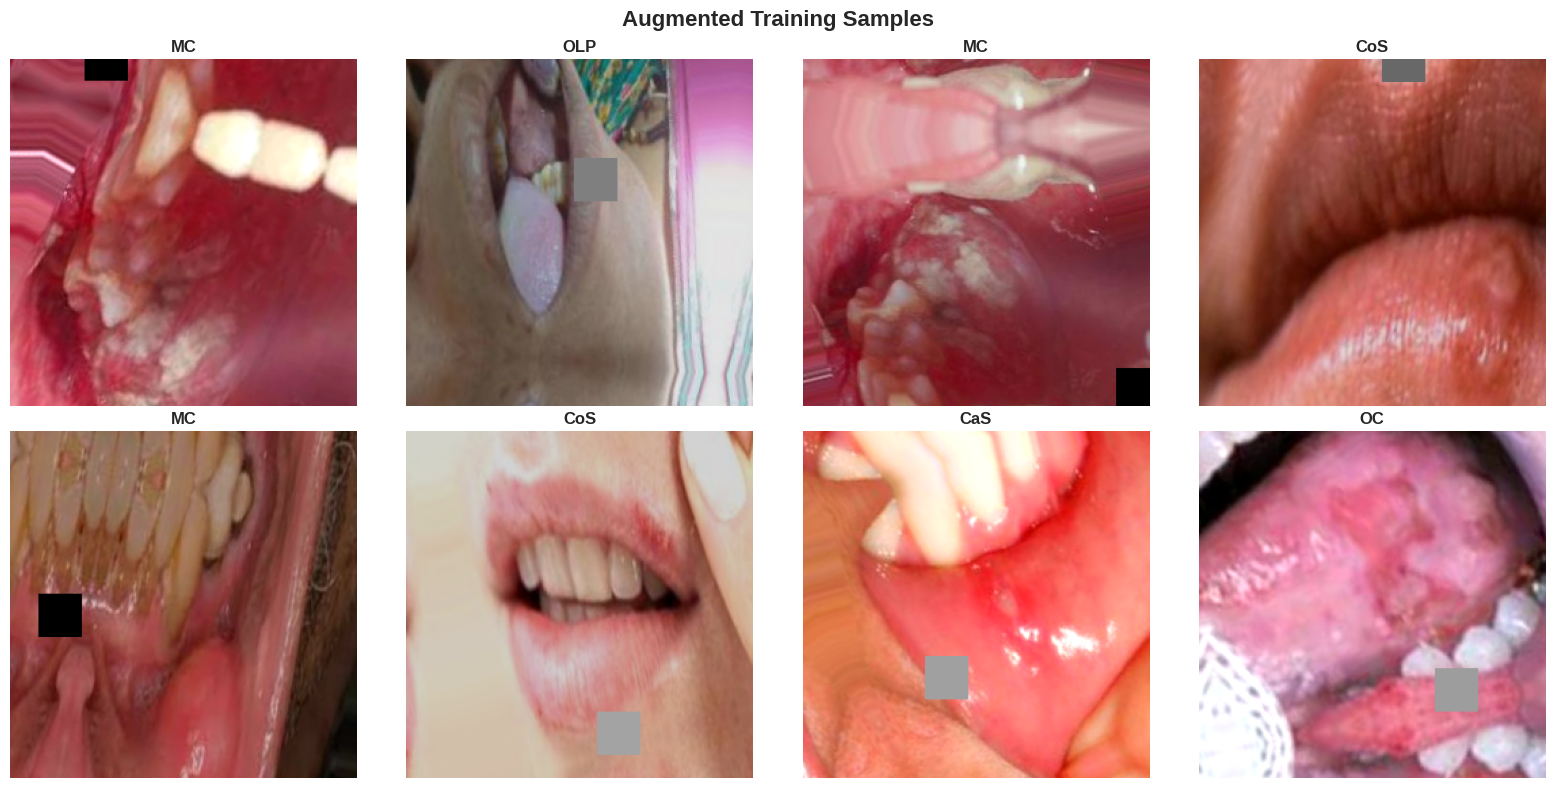

In [9]:
# Visualize augmentation
def show_augmentation_samples(generator, num_samples=8):
    images, labels = next(generator)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i in range(min(num_samples, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(f'{categories[class_idx]}', fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Augmented Training Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_augmentation_samples(train_generator)

##  STEP 7: Calculate Sophisticated Class Weights

In [10]:
def calculate_sophisticated_class_weights(df, method='balanced_sqrt'):
    """Calculate class weights with square root strategy"""

    train_df = df[df['split'] == 'train']
    class_counts = train_df['class'].value_counts().to_dict()
    total_samples = len(train_df)
    num_classes = len(class_counts)

    class_to_idx = {cls: idx for idx, cls in enumerate(sorted(class_counts.keys()))}

    weights = {}

    for cls, count in class_counts.items():
        idx = class_to_idx[cls]

        if method == 'balanced':
            weights[idx] = total_samples / (num_classes * count)
        elif method == 'balanced_sqrt':
            weight = total_samples / (num_classes * count)
            weights[idx] = np.sqrt(weight)  # Less aggressive

    # Normalize
    weight_sum = sum(weights.values())
    weights = {k: v / weight_sum * num_classes for k, v in weights.items()}

    return weights, class_to_idx

class_weights, class_to_idx = calculate_sophisticated_class_weights(df)

print("="*80)
print("CLASS WEIGHTS (Balanced SQRT Method)")
print("="*80)
print(f"{'Class':<10} {'Index':<8} {'Weight':<10}")
print("-"*80)
for cls, idx in sorted(class_to_idx.items(), key=lambda x: x[1]):
    print(f"{cls:<10} {idx:<8} {class_weights[idx]:.4f}")
print("="*80)

config.CLASS_WEIGHTS = class_weights

CLASS WEIGHTS (Balanced SQRT Method)
Class      Index    Weight    
--------------------------------------------------------------------------------
CaS        0        0.9465
CoS        1        0.9776
Gum        2        1.0930
MC         3        0.8924
OC         4        1.1521
OLP        5        0.8924
OT         6        1.0461


##  STEP 8: Build Optimized Model with Residual Connections

In [11]:
def se_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block"""
    channels = input_tensor.shape[-1]

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)

    return layers.Multiply()([input_tensor, se])

def residual_block(x, filters, kernel_size=3, stride=1, use_se=True):
    """Residual block with SE attention"""

    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                     kernel_regularizer=keras.regularizers.l2(config.L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same',
                     kernel_regularizer=keras.regularizers.l2(config.L2_REG))(x)
    x = layers.BatchNormalization()(x)

    if use_se:
        x = se_block(x)

    # Shortcut
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

def build_optimized_model(config):
    """Build optimized CNN with residual connections and SE blocks"""

    inputs = layers.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, 3))

    # Initial conv
    x = layers.Conv2D(32, 7, strides=2, padding='same',
                     kernel_regularizer=keras.regularizers.l2(config.L2_REG))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # Block 1: 32 filters
    x = residual_block(x, 32, use_se=True)
    x = residual_block(x, 32, use_se=True)
    x = layers.Dropout(0.2)(x)

    # Block 2: 64 filters
    x = residual_block(x, 64, stride=2, use_se=True)
    x = residual_block(x, 64, use_se=True)
    x = layers.Dropout(0.25)(x)

    # Block 3: 128 filters
    x = residual_block(x, 128, stride=2, use_se=True)
    x = residual_block(x, 128, use_se=True)
    x = residual_block(x, 128, use_se=True)
    x = layers.Dropout(0.3)(x)

    # Block 4: 256 filters
    x = residual_block(x, 256, stride=2, use_se=True)
    x = residual_block(x, 256, use_se=True)
    x = layers.Dropout(0.3)(x)

    # Global pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Dense layers
    x = layers.Dense(512, kernel_regularizer=keras.regularizers.l2(config.L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)

    x = layers.Dense(256, kernel_regularizer=keras.regularizers.l2(config.L2_REG))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(config.DROPOUT_RATE)(x)

    # Output with float32
    outputs = layers.Dense(config.NUM_CLASSES, activation='softmax', dtype='float32')(x)

    model = Model(inputs=inputs, outputs=outputs, name='OptimizedTeethClassifier')

    return model

# Build model
model = build_optimized_model(config)

print("="*80)
print("MODEL ARCHITECTURE")
print("="*80)
model.summary()
print("="*80)

MODEL ARCHITECTURE


Model: "OptimizedTeethClassifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │         66 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │         96 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ multiply[0][0],   │
│                     │ 32)               │            │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation_2[0][

 Total params: 3,395,019 (12.95 MB)

 Trainable params: 3,388,171 (12.92 MB)

 Non-trainable params: 6,848 (26.75 KB)

##  STEP 9: Define Learning Rate Schedule

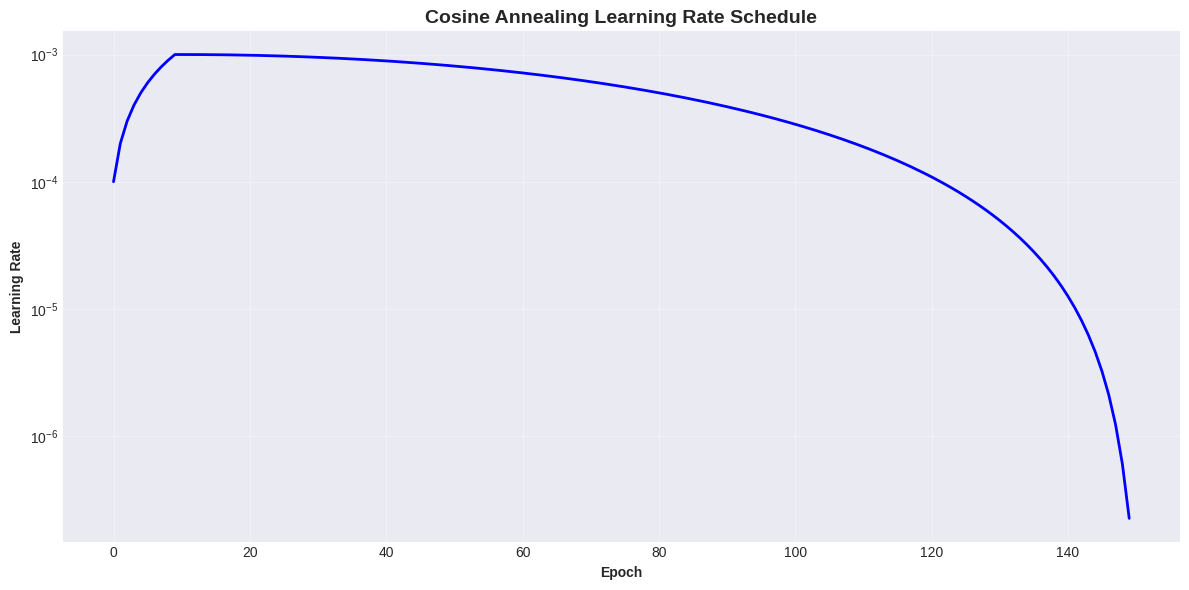

 Learning rate schedule created
   Initial LR: 0.001
   Min LR: 1e-07
   Warm-up: 10 epochs


In [12]:
def cosine_annealing_schedule(epoch, initial_lr, epochs, min_lr=1e-7):
    """Cosine annealing with warm-up"""
    if epoch < 10:
        # Warm-up
        return initial_lr * (epoch + 1) / 10
    else:
        # Cosine annealing
        progress = (epoch - 10) / (epochs - 10)
        return min_lr + 0.5 * (initial_lr - min_lr) * (1 + np.cos(np.pi * progress))

# Visualize LR schedule
epochs_range = np.arange(config.EPOCHS)
lrs = [cosine_annealing_schedule(e, config.INITIAL_LR, config.EPOCHS, config.MIN_LR)
       for e in epochs_range]

plt.figure(figsize=(12, 6))
plt.plot(epochs_range, lrs, linewidth=2, color='blue')
plt.title('Cosine Annealing Learning Rate Schedule', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Learning Rate', fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f" Learning rate schedule created")
print(f"   Initial LR: {config.INITIAL_LR}")
print(f"   Min LR: {config.MIN_LR}")
print(f"   Warm-up: 10 epochs")

##  STEP 10: Compile Model with Label Smoothing

In [13]:
# Compile with label smoothing
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=config.INITIAL_LR),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=config.LABEL_SMOOTHING),
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

print("="*80)
print("MODEL COMPILED")
print("="*80)
print(f"Optimizer: Adam (initial_lr={config.INITIAL_LR})")
print(f"Loss: CategoricalCrossentropy (label_smoothing={config.LABEL_SMOOTHING})")
print(f"Metrics: Accuracy, Top-3 Accuracy")
print(f"Class Weights: Enabled (balanced_sqrt)")
print("="*80)

MODEL COMPILED
Optimizer: Adam (initial_lr=0.001)
Loss: CategoricalCrossentropy (label_smoothing=0.1)
Metrics: Accuracy, Top-3 Accuracy
Class Weights: Enabled (balanced_sqrt)


##  STEP 11: Setup Advanced Callbacks

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

callbacks = [
    ModelCheckpoint(
        filepath=f'/content/best_model_optimized_{timestamp}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    ),

    LearningRateScheduler(
        lambda epoch: cosine_annealing_schedule(epoch, config.INITIAL_LR, config.EPOCHS, config.MIN_LR),
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=config.MIN_LR,
        verbose=1
    )
]

print(" Callbacks configured:")
print("   - ModelCheckpoint (save best)")
print("   - EarlyStopping (patience=25)")
print("   - LearningRateScheduler (cosine annealing)")
print("   - ReduceLROnPlateau (backup)")

 Callbacks configured:
   - ModelCheckpoint (save best)
   - EarlyStopping (patience=25)
   - LearningRateScheduler (cosine annealing)
   - ReduceLROnPlateau (backup)


##  STEP 12: Train the Optimized Model

In [ ]:
print("="*80)
print("STARTING TRAINING - OPTIMIZED MODEL")
print("="*80)
print(f"Epochs: {config.EPOCHS}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Using class weights: Yes")
print(f"Advanced augmentation: Yes (Cutout, Heavy transforms)")
print(f"Mixed precision: Yes")
print("="*80)

history = model.fit(
    train_generator,
    epochs=config.EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=config.CLASS_WEIGHTS,
    verbose=1
)

print("\n" + "="*80)
print("✅ TRAINING COMPLETE!")
print("="*80)

STARTING TRAINING - OPTIMIZED MODEL
Epochs: 150
Batch Size: 16
Training samples: 3087
Validation samples: 1028
Steps per epoch: 193
Using class weights: Yes
Advanced augmentation: Yes (Cutout, Heavy transforms)
Mixed precision: Yes

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.1853 - loss: 2.4620 - top_3_accuracy: 0.4797
Epoch 1: val_accuracy improved from -inf to 0.16634, saving model to /content/best_model_optimized_20260207_173419.keras
193/193 ━━━━━━━━━━━━━━━━━━━━ 166s 546ms/step - accuracy: 0.1854 - loss: 2.4617 - top_3_accuracy: 0.4798 - val_accuracy: 0.1663 - val_loss: 2.3530 - val_top_3_accuracy: 0.4757 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002.
Epoch 2/150
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2304 - loss: 2.3004 - top_3_accuracy: 0.5609
Epoch 2: val_accuracy did not improve from 0.16634
193/193 ━━━━━━━━━━━━━━━━━━━━ 59s 30

##  STEP 13: Plot Training History

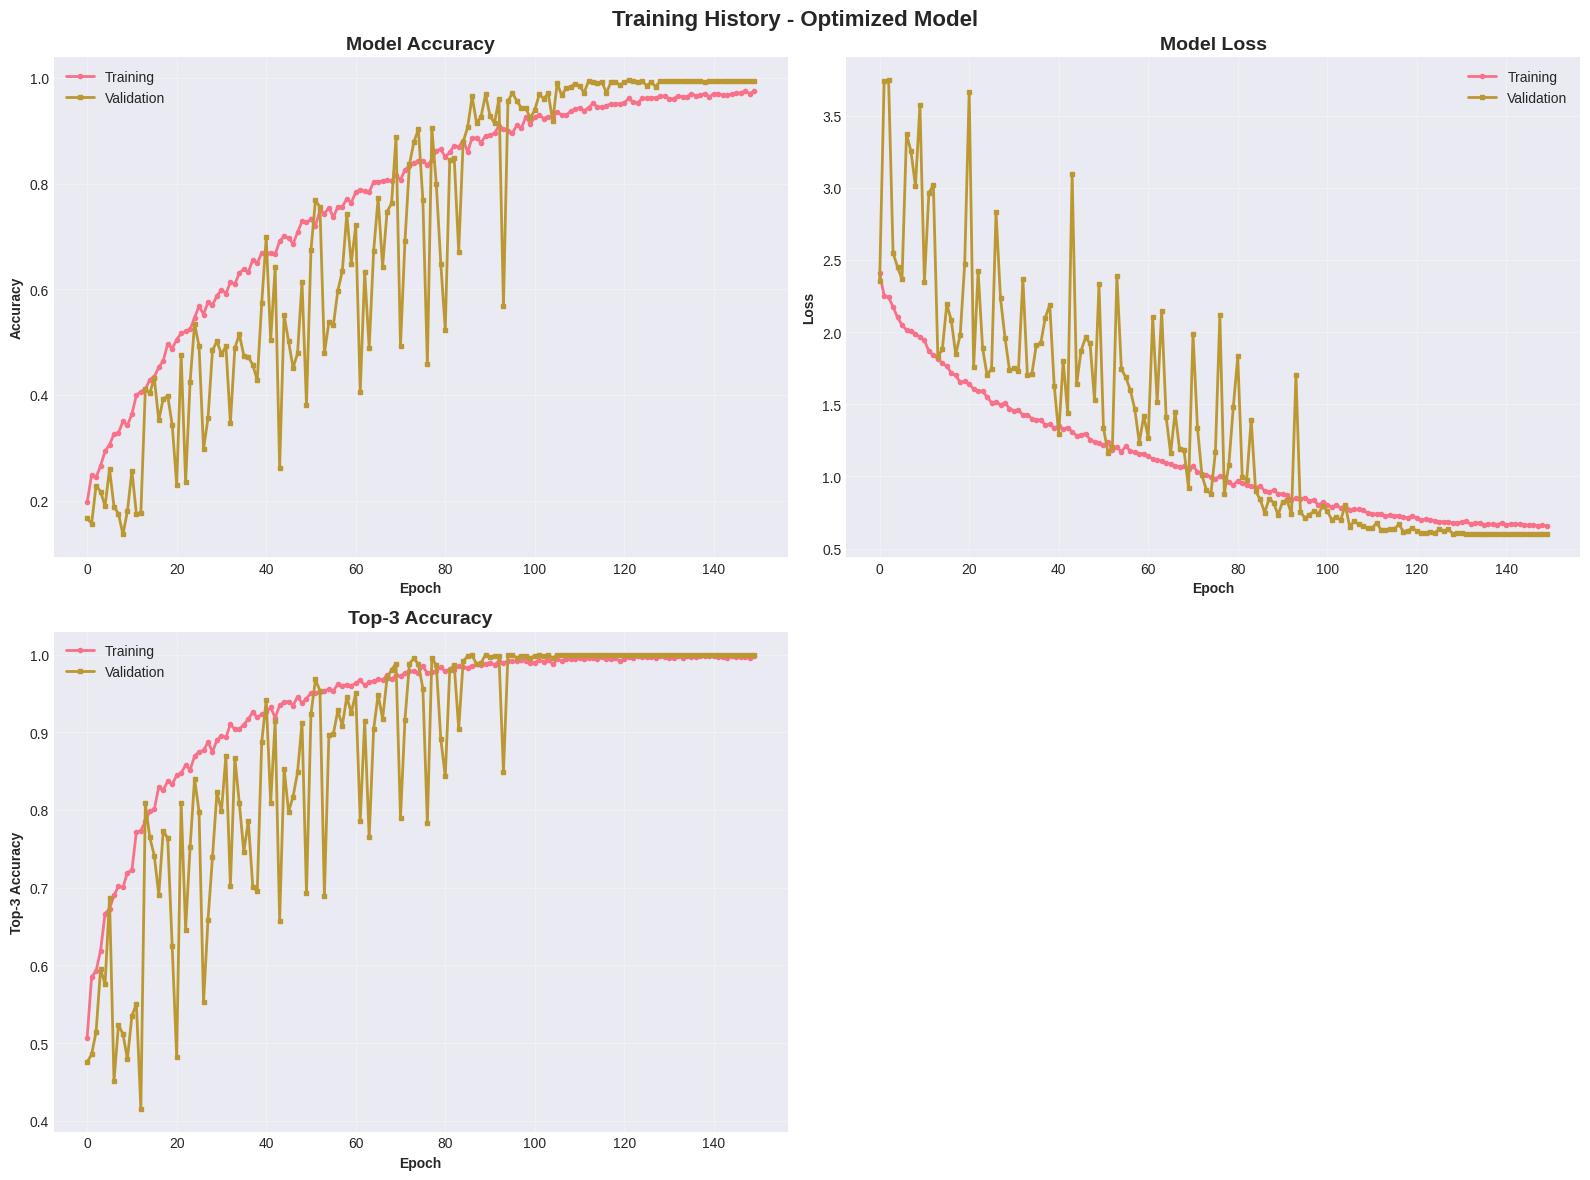


TRAINING SUMMARY
Final Training Accuracy:   0.9754 (97.54%)
Final Validation Accuracy: 0.9942 (99.42%)
Final Training Loss:       0.6557
Final Validation Loss:     0.6000

Best Validation Accuracy:  0.9961 (99.61%)
Best Epoch: 122
Total Epochs Trained: 150


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training', linewidth=2, marker='o', markersize=3)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s', markersize=3)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training', linewidth=2, marker='o', markersize=3)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=3)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Top-3 Accuracy
axes[1, 0].plot(history.history['top_3_accuracy'], label='Training', linewidth=2, marker='o', markersize=3)
axes[1, 0].plot(history.history['val_top_3_accuracy'], label='Validation', linewidth=2, marker='s', markersize=3)
axes[1, 0].set_title('Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Top-3 Accuracy', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='red', marker='o', markersize=3)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].set_ylabel('Learning Rate', fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].axis('off')

plt.suptitle('Training History - Optimized Model', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/training_history_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"Final Training Accuracy:   {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f} ({history.history['val_accuracy'][-1]*100:.2f}%)")
print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")
print(f"\nBest Validation Accuracy:  {max(history.history['val_accuracy']):.4f} ({max(history.history['val_accuracy'])*100:.2f}%)")
print(f"Best Epoch: {np.argmax(history.history['val_accuracy']) + 1}")
print(f"Total Epochs Trained: {len(history.history['accuracy'])}")
print("="*80)

##  STEP 14: Evaluate on Test Set (with TTA)

In [ ]:
print("="*80)
print("TEST SET EVALUATION")
print("="*80)

# Standard evaluation
test_loss, test_acc, test_top3 = model.evaluate(test_generator, verbose=1)

print(f"\n📊 Test Set Performance (Standard):")
print(f"   Test Loss:         {test_loss:.4f}")
print(f"   Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   Top-3 Accuracy:    {test_top3:.4f} ({test_top3*100:.2f}%)")

# Get predictions for confusion matrix
y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

print("="*80)

TEST SET EVALUATION
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9991 - loss: 0.5909 - top_3_accuracy: 1.0000

📊 Test Set Performance (Standard):
   Test Loss:         0.5953
   Test Accuracy:     0.9981 (99.81%)
   Top-3 Accuracy:    1.0000 (100.00%)
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step


##  STEP 15: Classification Report

In [ ]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=categories, digits=4))
print("="*80)


CLASSIFICATION REPORT
              precision    recall  f1-score   support

         CaS     0.9938    1.0000    0.9969       160
         CoS     1.0000    1.0000    1.0000       149
         Gum     1.0000    1.0000    1.0000       120
          MC     1.0000    0.9944    0.9972       180
          OC     0.9908    1.0000    0.9954       108
         OLP     1.0000    0.9944    0.9972       180
          OT     1.0000    1.0000    1.0000       131

    accuracy                         0.9981      1028
   macro avg     0.9978    0.9984    0.9981      1028
weighted avg     0.9981    0.9981    0.9981      1028



##  STEP 16: Confusion Matrix

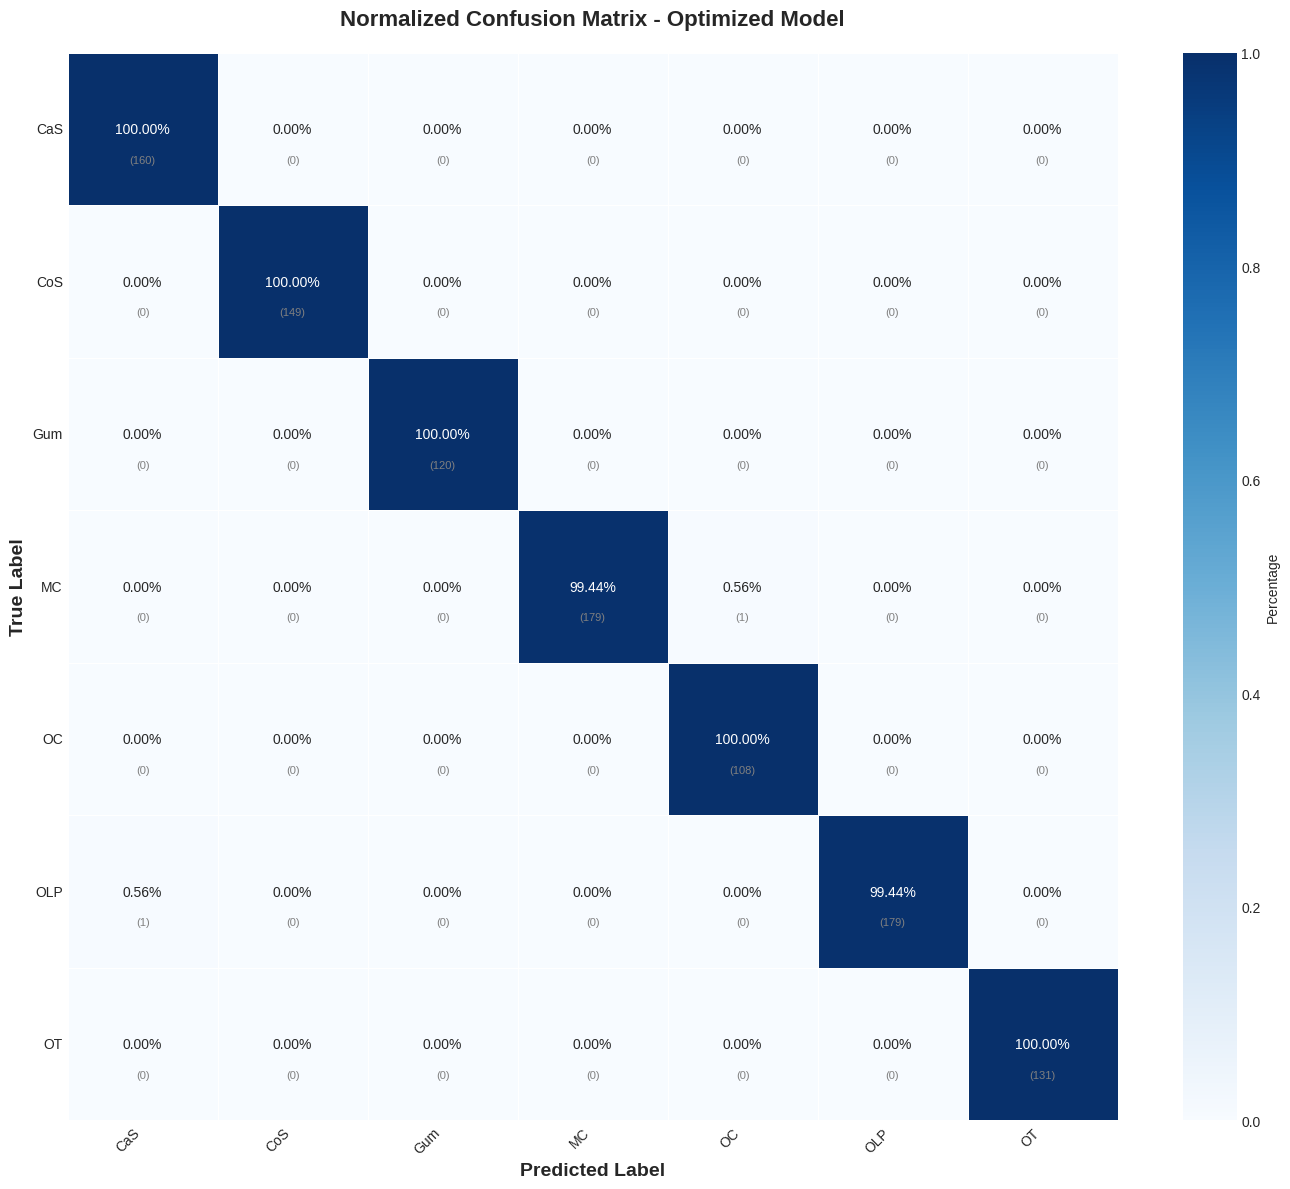

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Percentage'}, linewidths=0.5)

plt.title('Normalized Confusion Matrix - Optimized Model',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add counts
for i in range(len(categories)):
    for j in range(len(categories)):
        plt.text(j + 0.5, i + 0.7, f'({cm[i, j]})',
                ha='center', va='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('/content/confusion_matrix_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

##  STEP 17: Per-Class Metrics

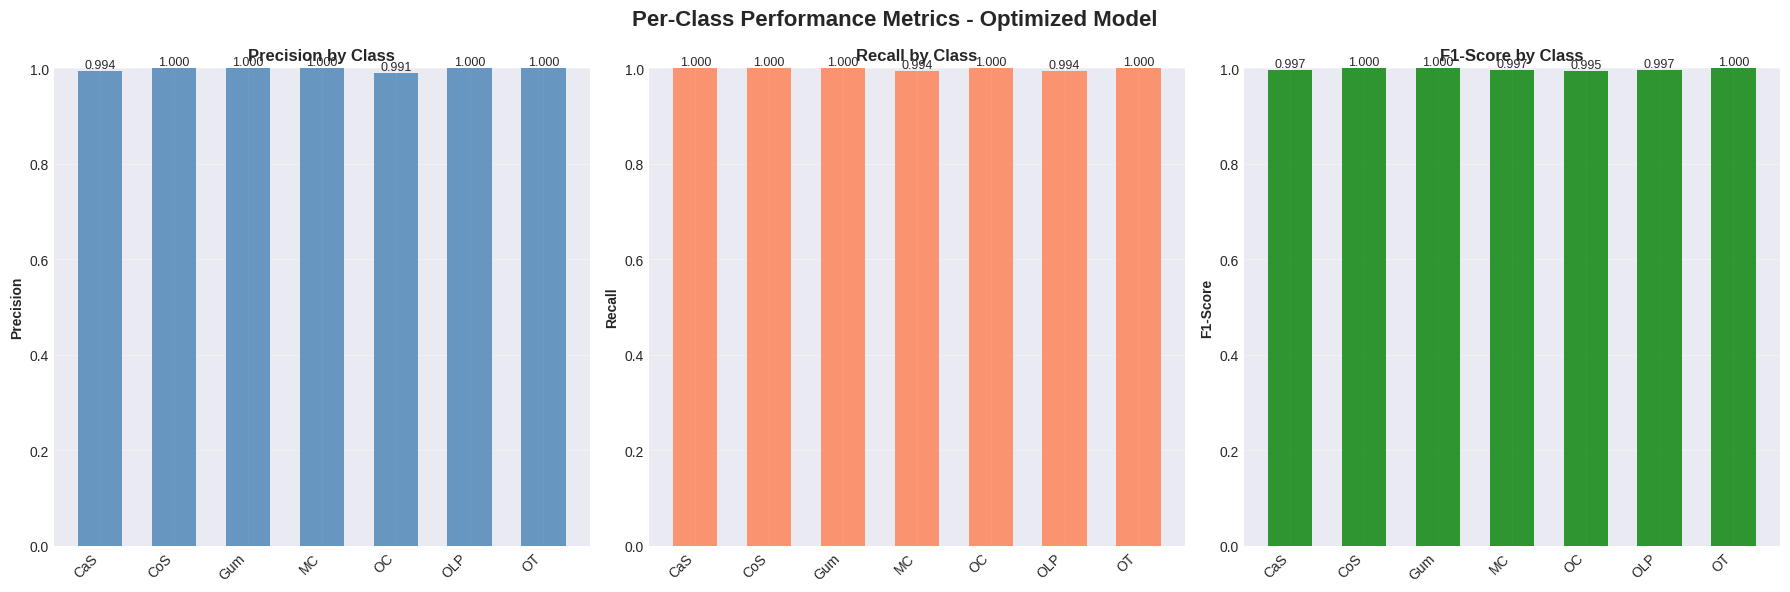


PER-CLASS METRICS
Class      Precision    Recall       F1-Score     Support   
--------------------------------------------------------------------------------
CaS        0.9938       1.0000       0.9969       160       
CoS        1.0000       1.0000       1.0000       149       
Gum        1.0000       1.0000       1.0000       120       
MC         1.0000       0.9944       0.9972       180       
OC         0.9908       1.0000       0.9954       108       
OLP        1.0000       0.9944       0.9972       180       
OT         1.0000       1.0000       1.0000       131       


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=range(len(categories))
)

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
x = np.arange(len(categories))
width = 0.6

# Precision
bars1 = axes[0].bar(x, precision, width, color='steelblue', alpha=0.8)
axes[0].set_ylabel('Precision', fontweight='bold')
axes[0].set_title('Precision by Class', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=45, ha='right')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Recall
bars2 = axes[1].bar(x, recall, width, color='coral', alpha=0.8)
axes[1].set_ylabel('Recall', fontweight='bold')
axes[1].set_title('Recall by Class', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories, rotation=45, ha='right')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# F1-Score
bars3 = axes[2].bar(x, f1, width, color='green', alpha=0.8)
axes[2].set_ylabel('F1-Score', fontweight='bold')
axes[2].set_title('F1-Score by Class', fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(categories, rotation=45, ha='right')
axes[2].set_ylim([0, 1])
axes[2].grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Per-Class Performance Metrics - Optimized Model',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/per_class_metrics_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

# Print table
print("\n" + "="*80)
print("PER-CLASS METRICS")
print("="*80)
print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*80)
for i, cat in enumerate(categories):
    print(f"{cat:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f} {support[i]:<10}")
print("="*80)

##  STEP 18: Save Model and Artifacts

In [ ]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save final model
final_model_path = f'/content/optimized_teeth_model_final_{timestamp}.keras'
model.save(final_model_path)
print(f"✅ Model saved: {final_model_path}")

# Save history
history_dict = {key: [float(val) for val in values]
               for key, values in history.history.items()}
history_path = f'/content/training_history_{timestamp}.json'
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=2)
print(f"✅ History saved: {history_path}")

# Save results
results = {
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'test_top3': float(test_top3),
    'class_names': categories,
    'precision': precision.tolist(),
    'recall': recall.tolist(),
    'f1': f1.tolist(),
    'support': support.tolist()
}
results_path = f'/content/evaluation_results_{timestamp}.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"✅ Results saved: {results_path}")

# Save configuration
config_dict = {key: value for key, value in vars(config).items()
              if not key.startswith('_')}
config_path = f'/content/model_config_{timestamp}.json'
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=2, default=str)
print(f"✅ Config saved: {config_path}")

print("\n" + "="*80)
print("ALL ARTIFACTS SAVED SUCCESSFULLY")
print("="*80)

✅ Model saved: /content/optimized_teeth_model_final_20260207_200712.keras
✅ History saved: /content/training_history_20260207_200712.json
✅ Results saved: /content/evaluation_results_20260207_200712.json
✅ Config saved: /content/model_config_20260207_200712.json

ALL ARTIFACTS SAVED SUCCESSFULLY
